In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [8]:
# Import necessary libraries
from src.models import RNNModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn
import scipy.signal as signal

# Set data type and device
dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = torch.device("cpu")
print(device)
# Close all open plots
plt.close('all')

cuda


In [9]:
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output.mat')
data_out = scipy.io.loadmat(filepath)

# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__ = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__']
    
nExp = yExp.size


In [10]:
# Create time vector
#t = np.arange(0, np.size(dExp[0, 0], 1) * Ts, Ts)
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
input_size = 5
u = torch.zeros(nExp, t_end, input_size)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = input_size-1

# Fill input and output tensors with data
for j in range(nExp):
    #inputActive = (torch.from_numpy(dExp[0, j]))
    #if input_size ==4:
     #   u[j, :, :] = (torch.from_numpy(dExp[0, j][:, :-1])) #suppress last column
    #else :
    u[j, :, :] = (torch.from_numpy(dExp[0, j]))        
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))
    
    #u[j, :, 4] = torch.from_numpy(signal.medfilt((u[j, :, 4]).numpy(), 13))
    #plt.plot(u[j, :, 4])

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

In [11]:
import torch
import torch.nn as nn
import numpy as np
import optuna
# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, input_size)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    inputActive = (torch.from_numpy(dExp_val[0, j]))
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    
# Set number of epochs
epochs = 100   
# Initialize array to store loss values
LOSS = np.zeros(epochs)

# Set dimensions for RNN layers
idd = input_size
odd = yExp[0, 0].shape[1]

# Define the Optuna objective function
def objective(trial):
    # Suggest values for hdd and ldd using Optuna
    hdd = trial.suggest_int("hdd", 10, 100, step=10)
    ldd = trial.suggest_int("ldd", 1, 2)
    print(f"Training RNN with hdd={hdd} and ldd={ldd}")

    # Initialize the RNN model with suggested parameters
    RNN = RNNModel(idd, hdd, ldd, odd)
    MSE = nn.MSELoss()

    # Define optimizer
    learning_rate = 1.0e-2
    optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    optimizer.zero_grad()

    # Training loop
    for epoch in range(epochs):
        # Update learning rate at certain epochs
        if epoch == epochs // 2:
            optimizer = torch.optim.Adam(RNN.parameters(), lr=1.0e-3)
        if epoch == epochs // 6:
            optimizer = torch.optim.Adam(RNN.parameters(), lr=1.0e-4)

        # Forward pass and loss computation
        yRNN = RNN(u)#.squeeze()
        loss = MSE(yRNN, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LOSS[epoch] = loss.item()

    # Validate model on validation set
    yRNN_val = RNN(uval)#.squeeze()
    loss_val = MSE(yRNN_val, yval).item()

    return loss_val

# Set up Optuna study and optimize
study = optuna.create_study(direction="minimize",pruner=optuna.pruners.NopPruner())
study.optimize(objective, n_trials=7, timeout=1800)

# Display results
print("Number of finished trials:", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value:", trial.value)
print("  Params:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Final training with best hyperparameters
best_hdd = trial.params["hdd"]
best_ldd = trial.params["ldd"]

best_RNN = RNNModel(idd, best_hdd, best_ldd, odd)
best_optimizer = torch.optim.Adam(best_RNN.parameters(), lr=1.0e-2)
best_optimizer.zero_grad()
loss = nn.MSELoss()

# Training and validation loop
for epoch in range(epochs):
    if epoch == epochs // 2:
        best_optimizer = torch.optim.Adam(best_RNN.parameters(), lr=1.0e-3)
    if epoch == epochs // 6:
        best_optimizer = torch.optim.Adam(best_RNN.parameters(), lr=1.0e-4)

    y_pred = best_RNN(u).squeeze()
    loss_value = loss(y_pred, y)
    loss_value.backward()
    best_optimizer.step()
    best_optimizer.zero_grad()

yRNN_val = best_RNN(uval).squeeze()

# Save final model
torch.save(best_RNN.state_dict(), 'best_RNN.pth')
print(f"Final model saved with hdd={best_hdd}, ldd={best_ldd} and validation loss={trial.value}")

[I 2024-11-07 16:46:30,936] A new study created in memory with name: no-name-c943e400-6c95-4782-8002-0640f8893305


Training RNN with hdd=100 and ldd=1


[W 2024-11-07 16:47:17,145] Trial 0 failed with parameters: {'hdd': 100, 'ldd': 1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\adela\anaconda3\envs\sysid\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\adela\AppData\Local\Temp\ipykernel_8344\3666500935.py", line 54, in objective
    loss.backward()
  File "c:\Users\adela\anaconda3\envs\sysid\Lib\site-packages\torch\_tensor.py", line 521, in backward
    torch.autograd.backward(
  File "c:\Users\adela\anaconda3\envs\sysid\Lib\site-packages\torch\autograd\__init__.py", line 289, in backward
    _engine_run_backward(
  File "c:\Users\adela\anaconda3\envs\sysid\Lib\site-packages\torch\autograd\graph.py", line 769, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [6]:
#Set dimensions for RNN layers
idd = input_size
hdd = 10
ldd = 2
odd = yExp[0, 0].shape[1]

# Initialize RNN model
RNN = RNNModel(idd, hdd, ldd, odd)
# Load the model parameters before starting a new training session
#RNN.load_state_dict(torch.load('parameters_RNN.pth'))

# Define loss function
MSE = nn.MSELoss()

# Define optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Set number of epochs
epochs = 300

# Initialize array to store loss values
LOSS = np.zeros(epochs)



# Train the RNN model
for epoch in range(epochs):
    # Adjust learning rate at certain epochs
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    # Get RNN output for training data
    yRNN = RNN(u)
    yRNN = torch.squeeze(yRNN)
    

    # Calculate loss and backpropagate
    loss = MSE(yRNN, y)
    loss.backward()
    optimizer.step()
    

    # Print loss for current epoch
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss
    
    # Save model parameters every 15 epochs
    if (epoch + 1) % 15 == 0:
        torch.save(RNN.state_dict(), f'parameters_RNN.pth')
        print(f"Model parameters saved at epoch {epoch + 1}")

Epoch: 1 	||	 Loss: 0.42185890674591064
Epoch: 2 	||	 Loss: 0.27130138874053955
Epoch: 3 	||	 Loss: 0.16574354469776154
Epoch: 4 	||	 Loss: 0.09330904483795166


KeyboardInterrupt: 

In [ ]:
# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, input_size)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    inputActive = (torch.from_numpy(dExp_val[0, j]))#[:,:-1]))
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    #uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 25))

# Get RNN output for validation data
yRNN_val = RNN(uval)
yRNN_val = yRNN_val.unsqueeze_(0)

# Calculate loss for validation data
loss_val = MSE(yRNN_val, yval)

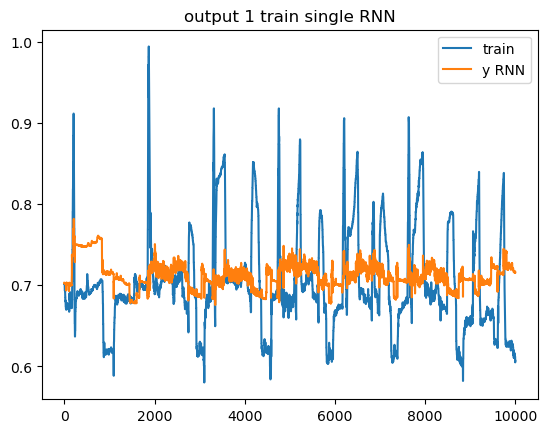

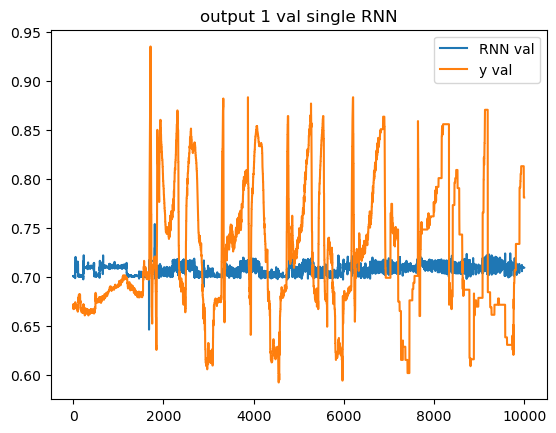

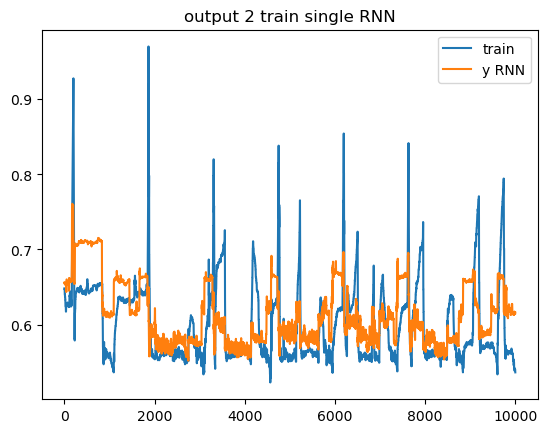

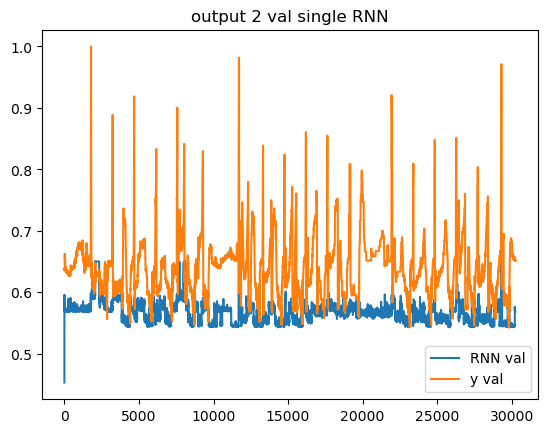

Loss Validation single RNN: 0.005824914667755365


In [ ]:
# Plot loss over epochs
#plt.figure('8')
#plt.plot(LOSS)
#plt.title("LOSS")
#plt.show()

# Plot output 1 for training data
plt.figure('9')
plt.plot(y[0, 10000:20000, 0].detach().numpy(), label='train')
plt.plot(yRNN[0, 10000:20000, 0].detach().numpy(), label='y RNN')
plt.title("output 1 train single RNN")
plt.legend()
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(yRNN_val[0, 10000:20000, 0].detach().numpy(), label='RNN val')
plt.plot(yval[0, 10000:20000, 0].detach().numpy(), label='y val')
plt.title("output 1 val single RNN")
plt.legend()
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(y[0, 10000:20000, 1].detach().numpy(), label='train')
plt.plot(yRNN[0, 10000:20000, 1].detach().numpy(), label='y RNN')
plt.title("output 2 train single RNN")
plt.legend()
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(yRNN_val[0, :, 1].detach().numpy(), label='RNN val')
plt.plot(yval[0, :, 1].detach().numpy(), label='y val')
plt.title("output 2 val single RNN")
plt.legend()
plt.show()

# Save RNN output and validation data to file
#scipy.io.savemat('data_singleRNN_sysID.mat', dict(yRENm_val=yRNN_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
print(f"Loss Validation single RNN: {loss_val}")

In [ ]:
#0.006431 (90,1)
#0.007636 (100,1)
#0.005824 (10,2)